## Optional Lab: Diagnosing Bias and Variance

Laboratorio : Diagnóstico de Sesgo y Varianza

Viste cómo evaluar el rendimiento de un algoritmo de aprendizaje midiendo su error en el conjunto de entrenamiento y en la validación cruzada. Con estos valores, puedes cuantificar qué tan bien está funcionando un modelo, lo que te ayuda a tomar decisiones sobre cuál usar para una aplicación dada. En este laboratorio, continuarás con este proceso y explorarás algunos consejos para mejorar el rendimiento de tus modelos. Resulta que los errores de entrenamiento y validación cruzada pueden indicarte qué hacer a continuación para mejorar tus modelos. Específicamente, te mostrarán si tienes un problema de alto sesgo (subajuste) o alta varianza (sobreajuste).

El problema de alto sesgo, donde el modelo no está capturando los patrones en los datos de entrenamiento. Como resultado, tendrás un alto error de entrenamiento y validación cruzada. Ahora alta varianza, donde el modelo ha sobreajustado el conjunto de entrenamiento. Por lo tanto, aunque tenga un bajo error de entrenamiento, su rendimiento será pobre en nuevos ejemplos, lo que se indica con un alto error de validación cruzada. El modelo ideal es donde el modelo aprende exitosamente del conjunto de entrenamiento y también generaliza bien a datos no vistos. Algunos consejos sobre qué hacer a continuación para lograr este modelo "perfecto".



## Para corregir un problema de alto sesgo, puedes:

* Intentar agregar características polinomiales
* Intentar obtener características adicionales
* Intentar disminuir el parámetro de regularización

##Para corregir un problema de alta varianza, puedes:

* Intentar aumentar el parámetro de regularización
* Intentar conjuntos de características más pequeños
* Obtener más ejemplos de entrenamiento
* Probarás todos estos consejos en este laboratorio. ¡Empecemos!

##UTILS FUNCTIONS

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def plot_dataset(x, y, title):
    plt.rcParams["figure.figsize"] = (12,8)
    plt.rcParams["lines.markersize"] = 12
    plt.scatter(x, y, marker='x', c='r');
    plt.title(title)
    plt.xlabel("x");
    plt.ylabel("y");
    plt.show()

def plot_train_cv_test(x_train, y_train, x_cv, y_cv, x_test, y_test, title):
    plt.scatter(x_train, y_train, marker='x', c='r', label='training');
    plt.scatter(x_cv, y_cv, marker='o', c='b', label='cross validation');
    plt.scatter(x_test, y_test, marker='^', c='g', label='test');
    plt.title("input vs. target")
    plt.xlabel("x");
    plt.ylabel("y");
    plt.legend()
    plt.show()

def plot_train_cv_mses(degrees, train_mses, cv_mses, title):
    degrees = range(1,11)
    plt.plot(degrees, train_mses, marker='o', c='r', label='training MSEs');
    plt.plot(degrees, cv_mses, marker='o', c='b', label='CV MSEs');
    plt.title(title)
    plt.xlabel("degree");
    plt.ylabel("MSE");
    plt.legend()
    plt.show()

def plot_bc_dataset(x, y, title):
    for i in range(len(y)):
        marker = 'x' if y[i] == 1 else 'o'
        c = 'r' if y[i] == 1 else 'b'
        plt.scatter(x[i,0], x[i,1], marker=marker, c=c);
    plt.title("x1 vs x2")
    plt.xlabel("x1");
    plt.ylabel("x2");
    y_0 = mlines.Line2D([], [], color='r', marker='x', markersize=12, linestyle='None', label='y=1')
    y_1 = mlines.Line2D([], [], color='b', marker='o', markersize=12, linestyle='None', label='y=0')
    plt.title(title)
    plt.legend(handles=[y_0, y_1])
    plt.show()

def build_models():

    tf.random.set_seed(20)

    model_1 = Sequential(
        [
            Dense(25, activation = 'relu'),
            Dense(15, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_1'
    )

    model_2 = Sequential(
        [
            Dense(20, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(20, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_2'
    )

    model_3 = Sequential(
        [
            Dense(32, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(4, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_3'
    )

    model_list = [model_1, model_2, model_3]

    return model_list


# Not used in the lab. You can call this for the binary
# classification problem if you set `from_logits=False`
# when declaring the loss. With this, you will also not need
# to call the `tf.math.sigmoid()` function in the loop
# because the model output is already a probability
def build_bc_models():

    tf.random.set_seed(20)

    model_1_bc = Sequential(
        [
            Dense(25, activation = 'relu'),
            Dense(15, activation = 'relu'),
            Dense(1, activation = 'sigmoid')
        ],
        name='model_1_bc'
    )

    model_2_bc = Sequential(
        [
            Dense(20, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(20, activation = 'relu'),
            Dense(1, activation = 'sigmoid')
        ],
        name='model_2_bc'
    )

    model_3_bc = Sequential(
        [
            Dense(32, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(4, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(1, activation = 'sigmoid')
        ],
        name='model_3_bc'
    )

    models_bc = [model_1_bc, model_2_bc, model_3_bc]

    return models_bc


def prepare_dataset(filename):

    data = np.loadtxt(filename, delimiter=",")

    x = data[:,:-1]
    y = data[:,-1]

    # Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
    x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=80)

    # Split the 40% subset above into two: one half for cross validation and the other for the test set
    x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=80)

    return x_train, y_train, x_cv, y_cv, x_test, y_test

def train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=None):

    train_mses = []
    cv_mses = []
    models = []
    scalers = []
    degrees = range(1,max_degree+1)

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for degree in degrees:

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model.fit(X_train_mapped_scaled, y_train )
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    plt.plot(degrees, train_mses, marker='o', c='r', label='training MSEs');
    plt.plot(degrees, cv_mses, marker='o', c='b', label='CV MSEs');
    plt.plot(degrees, np.repeat(baseline, len(degrees)), linestyle='--', label='baseline')
    plt.title("degree of polynomial vs. train and CV MSEs")
    plt.xticks(degrees)
    plt.xlabel("degree");
    plt.ylabel("MSE");
    plt.legend()
    plt.show()

def train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 1, baseline=None):

    train_mses = []
    cv_mses = []
    models = []
    scalers = []

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for reg_param in reg_params:

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model = Ridge(alpha=reg_param)
        model.fit(X_train_mapped_scaled, y_train)
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    reg_params = [str(x) for x in reg_params]
    plt.plot(reg_params, train_mses, marker='o', c='r', label='training MSEs');
    plt.plot(reg_params, cv_mses, marker='o', c='b', label='CV MSEs');
    plt.plot(reg_params, np.repeat(baseline, len(reg_params)), linestyle='--', label='baseline')
    plt.title("lambda vs. train and CV MSEs")
    plt.xlabel("lambda");
    plt.ylabel("MSE");
    plt.legend()
    plt.show()

def train_plot_diff_datasets(model, files, max_degree=10, baseline=None):

    for file in files:

        x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset(file['filename'])

        train_mses = []
        cv_mses = []
        models = []
        scalers = []
        degrees = range(1,max_degree+1)

        # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
        for degree in degrees:

            # Add polynomial features to the training set
            poly = PolynomialFeatures(degree, include_bias=False)
            X_train_mapped = poly.fit_transform(x_train)

            # Scale the training set
            scaler_poly = StandardScaler()
            X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
            scalers.append(scaler_poly)

            # Create and train the model
            model.fit(X_train_mapped_scaled, y_train )
            models.append(model)

            # Compute the training MSE
            yhat = model.predict(X_train_mapped_scaled)
            train_mse = mean_squared_error(y_train, yhat) / 2
            train_mses.append(train_mse)

            # Add polynomial features and scale the cross-validation set
            poly = PolynomialFeatures(degree, include_bias=False)
            X_cv_mapped = poly.fit_transform(x_cv)
            X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

            # Compute the cross-validation MSE
            yhat = model.predict(X_cv_mapped_scaled)
            cv_mse = mean_squared_error(y_cv, yhat) / 2
            cv_mses.append(cv_mse)

        # Plot the results
        plt.plot(degrees, train_mses, marker='o', c='r', linestyle=file['linestyle'], label=f"{file['label']} training MSEs");
        plt.plot(degrees, cv_mses, marker='o', c='b', linestyle=file['linestyle'], label=f"{file['label']} CV MSEs");

    plt.plot(degrees, np.repeat(baseline, len(degrees)), linestyle='--', label='baseline')
    plt.title("degree of polynomial vs. train and CV MSEs")
    plt.xticks(degrees)
    plt.xlabel("degree");
    plt.ylabel("MSE");
    plt.legend()
    plt.show()

def train_plot_learning_curve(model, x_train, y_train, x_cv, y_cv, degree= 1, baseline=None):

    train_mses = []
    cv_mses = []
    models = []
    scalers = []
    num_samples_train_and_cv = []
    percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for percent in percents:

        num_samples_train = round(len(x_train) * (percent/100.0))
        num_samples_cv = round(len(x_cv) * (percent/100.0))
        num_samples_train_and_cv.append(num_samples_train + num_samples_cv)

        x_train_sub = x_train[:num_samples_train]
        y_train_sub = y_train[:num_samples_train]
        x_cv_sub = x_cv[:num_samples_cv]
        y_cv_sub = y_cv[:num_samples_cv]

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train_sub)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model.fit(X_train_mapped_scaled, y_train_sub)
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train_sub, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv_sub)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv_sub, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    plt.plot(num_samples_train_and_cv, train_mses, marker='o', c='r', label='training MSEs');
    plt.plot(num_samples_train_and_cv, cv_mses, marker='o', c='b', label='CV MSEs');
    plt.plot(num_samples_train_and_cv, np.repeat(baseline, len(percents)), linestyle='--', label='baseline')
    plt.title("number of examples vs. train and CV MSEs")
    plt.xlabel("total number of training and cv examples");
    plt.ylabel("MSE");
    plt.legend()
    plt.show()

ModuleNotFoundError: No module named 'tensorflow'

# **ANALISIS DE BIAS Y VARIANZA DESDE AQUI**

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
path = '/content/drive/MyDrive/Colab Notebooks/notebooks ML1/'
filename = 'Dataparabiasysesgo.csv'

In [32]:
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset(f"{path}{filename}")
print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")

# Preview the first 5 rows
print(f"first 5 rows of the training inputs (1 feature):\n {x_train[:5]}\n")


the shape of the training set (input) is: (60, 1)
the shape of the training set (target) is: (60,)

the shape of the cross validation set (input) is: (20, 1)
the shape of the cross validation set (target) is: (20,)

first 5 rows of the training inputs (1 feature):
 [[3757.57575758]
 [2878.78787879]
 [3545.45454545]
 [1575.75757576]
 [1666.66666667]]



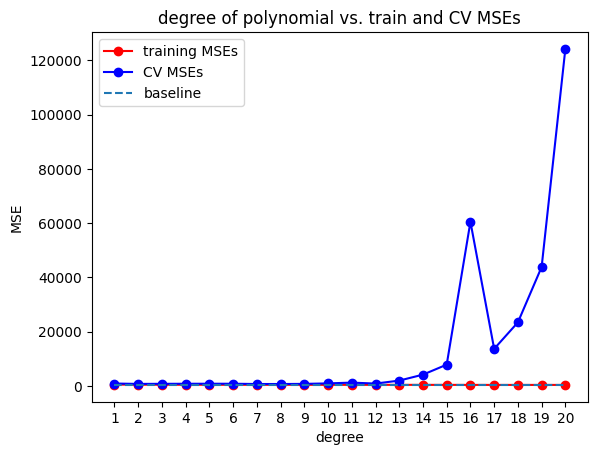

In [33]:
model = LinearRegression()

# Train and plot polynomial regression models
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=20, baseline=400) # cambia el valor del polinomio # diferentes datos de entrenamiento para que use todo el dataset
# grado 1 primer dato , en el polinomio grado dos el error bajo . # cambielo a 20 tengo un polinomio muy complejo
# cambiar varias veces el grado del polinimio para ver como se comporta con diferentes polinomios , experimentar

Como puedes ver, cuanto más agregas características polinómicas, mejor se ajusta el modelo a los datos de entrenamiento. En este ejemplo, incluso funcionó mejor que la línea base. En este punto, puedes decir que los modelos con un grado mayor a 4 tienen bajo sesgo porque su rendimiento está cerca o por encima de la línea base.

Sin embargo, si la línea base se define más baja , entonces los modelos se consideran aún de alto sesgo. Entonces puedes probar otros métodos para mejorar esto.



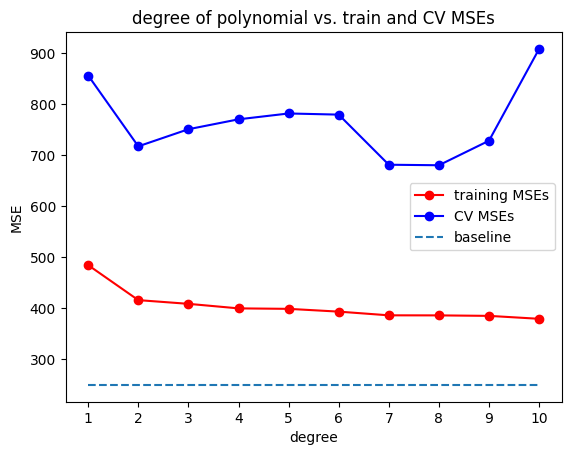

In [34]:
# Train and plot polynomial regression models. Bias is defined lower.
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=250)

##MORE FEATURES TO TREAT HIGH BIAS: Aumentando los datos

In [35]:
filename2 ='Dataparabiasysesgo2.csv'


In [37]:
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset(f"{path}{filename2}")

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")

# Preview the first 5 rows
print(f"first 5 rows of the training inputs (2 features):\n {x_train[:5]}\n")

the shape of the training set (input) is: (60, 2)
the shape of the training set (target) is: (60,)

the shape of the cross validation set (input) is: (20, 2)
the shape of the cross validation set (target) is: (20,)

first 5 rows of the training inputs (2 features):
 [[3.75757576e+03 5.49494949e+00]
 [2.87878788e+03 6.70707071e+00]
 [3.54545455e+03 3.71717172e+00]
 [1.57575758e+03 5.97979798e+00]
 [1.66666667e+03 1.61616162e+00]]



the shape of the training set (input) is: (60, 2) dos caracteristicas y 60 observaciones

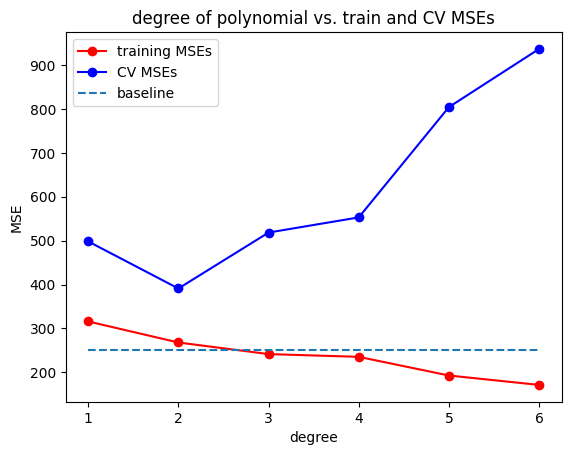

In [40]:
#Instantiate the model class
model = LinearRegression()

#Train and plot polynomial regression models. dataset used has 2 features
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=6, baseline=250)

cuando aumento el grado del polinomio sube , por que el modelo es muy complejo el mejor polinomio es mejor en 2, la diferencia entre laa validacion y entremmiento sea minima. Un error con lo que conoce y con lo que no conoce

### Try decreasing the regularization parameter

En este punto, podrías querer introducir regularización para evitar el sobreajuste. Una cosa a tener en cuenta es que podrías hacer que tus modelos subajusten si configuras el parámetro de regularización demasiado alto. La siguiente celda entrena un modelo polinomial de cuarto grado usando la clase Ridge, que te permite establecer un parámetro de regularización (es decir, lambda o 𝜆 λ). Probarás varios valores y compararás los resultados.

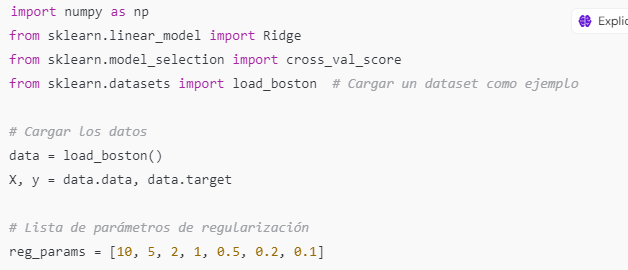

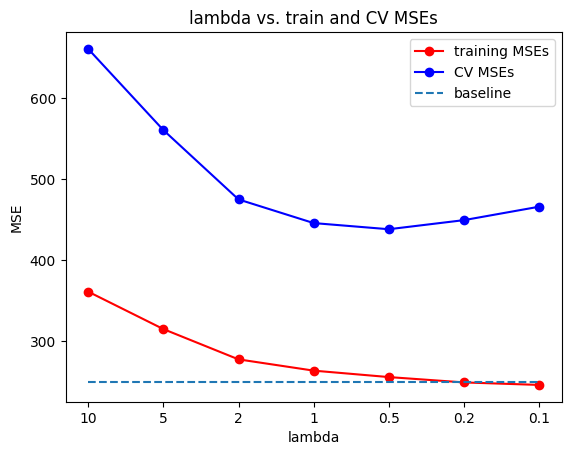

In [41]:
# Define lambdas to plot
reg_params = [10, 5, 2, 1, 0.5, 0.2, 0.1]

# Define degree of polynomial and train for each value of lambda
train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 4, baseline=250)

La gráfica resultante muestra un λ inicial de 10 y, como puedes ver, el error de entrenamiento es peor que la línea base en ese punto. Esto implica que se está aplicando una penalización muy alta a los parámetros w, lo que impide que el modelo aprenda patrones más complejos en tus datos. A medida que disminuyes 𝜆 λ, el modelo afloja esta restricción y el error de entrenamiento puede acercarse al rendimiento de la línea base.

**Prueba conjuntos de características más pequeños**

Ya has visto en el último laboratorio que tener demasiados términos polinomiales puede resultar en un sobreajuste. Puedes reducir la cantidad de estos términos y ver dónde obtienes el mejor equilibrio entre el error de entrenamiento y el de validación cruzada. Otro escenario donde reducir el número de características sería útil es cuando tienes características irrelevantes en tus datos. Por ejemplo, los identificadores de pacientes que proporcionan los hospitales no ayudarán a diagnosticar un tumor, por lo que debes asegurarte de eliminarlos de tus datos de entrenamiento.

Para ilustrar cómo la eliminación de características puede mejorar el rendimiento, realizarás una regresión polinomial para 2 conjuntos de datos: los mismos datos que usaste anteriormente (2 características) y otro con una columna de identificación aleatoria (3 características). Puedes previsualizar estos utilizando la celda a continuación. Observa que 2 columnas son idénticas y se añade una tercera columna que incluye números aleatorios.

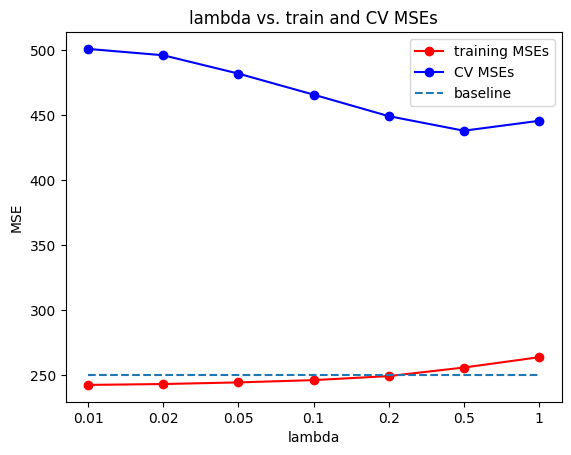

In [44]:
# Define lambdas to plot
reg_params = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

# Define degree of polynomial and train for each value of lambda
train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 4, baseline=250)

In [45]:
filename3 = 'Dataparabiasysesgo.csv'

In [50]:
# Prepare dataset with randomID feature
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset(f"{path}{filename2}")

# Preview the first 5 rows
print(f"first 5 rows of the training set with 2 features:\n {x_train[:5]}\n")

# Prepare dataset with randomID feature
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset(f"{path}{filename3}")

# Preview the first 5 rows
print(f"first 5 rows of the training set with 3 features (1st column is a random ID):\n {x_train[:5]}\n")

first 5 rows of the training set with 2 features:
 [[3.75757576e+03 5.49494949e+00]
 [2.87878788e+03 6.70707071e+00]
 [3.54545455e+03 3.71717172e+00]
 [1.57575758e+03 5.97979798e+00]
 [1.66666667e+03 1.61616162e+00]]

first 5 rows of the training set with 3 features (1st column is a random ID):
 [[3757.57575758]
 [2878.78787879]
 [3545.45454545]
 [1575.75757576]
 [1666.66666667]]



Ahora entrenarás los modelos y graficarás los resultados. Las líneas sólidas en la gráfica muestran los errores para los datos con 2 características, mientras que las líneas punteadas muestran los errores para el conjunto de datos con 3 características. Como puedes ver, el conjunto con 3 características tiene un error de validación cruzada más alto, especialmente a medida que introduces más términos polinomiales. Esto se debe a que el modelo también está tratando de aprender de los identificadores aleatorios, aunque no tienen nada que ver con la variable objetivo.

Otra forma de verlo es observar los puntos en grado=4  Notarás que, aunque el error de entrenamiento es más bajo con 3 características, la brecha entre el error de entrenamiento y el error de validación cruzada es mucho mayor que cuando solo utilizas 2 características. Esto también debería advertirte que el modelo está sobreajustando.

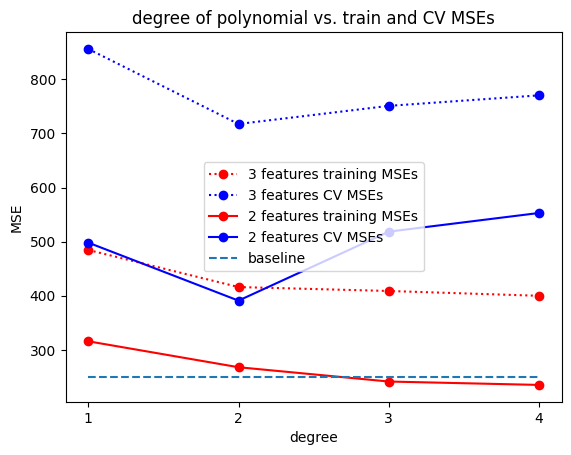

In [51]:
#Define the model
model = LinearRegression()

#Define properties of the 2 datasets
file1 = {'filename':f"{path}{filename3}", 'label': '3 features', 'linestyle': 'dotted'}
file2 = {'filename':f"{path}{filename2}", 'label': '2 features', 'linestyle': 'solid'}
files = [file1, file2]

#Train and plot for each dataset
train_plot_diff_datasets(model, files, max_degree=4, baseline=250)

In [54]:
filename4 = 'Dataparabiasysesgo4.csv'

the shape of the entire training set (input) is: (600, 2)
the shape of the entire training set (target) is: (600,)

the shape of the entire cross validation set (input) is: (200, 2)
the shape of the entire cross validation set (target) is: (200,)



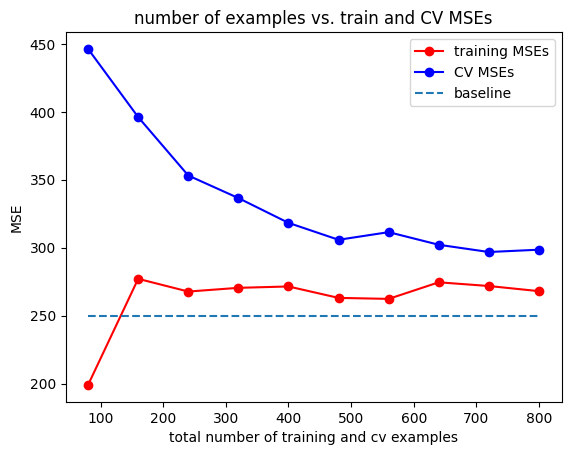

In [55]:
# Prepare the dataset
x_train, y_train, x_cv, y_cv, x_test, y_test = prepare_dataset(f'{path}{filename4}')
print(f"the shape of the entire training set (input) is: {x_train.shape}")
print(f"the shape of the entire training set (target) is: {y_train.shape}\n")
print(f"the shape of the entire cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the entire cross validation set (target) is: {y_cv.shape}\n")

# Instantiate the model class
model = LinearRegression()

# Define the degree of polynomial and train the model using subsets of the dataset.
train_plot_learning_curve(model, x_train, y_train, x_cv, y_cv, degree= 4, baseline=250)

Interpretación:
Entrenamiento: El MSE en el conjunto de entrenamiento disminuye rápidamente al principio y luego se estabiliza. Esto es esperable, ya que al aumentar el número de ejemplos, el modelo mejora su capacidad para ajustarse a los datos de entrenamiento.
Validación: El MSE en el conjunto de validación cruzada (CV) también disminuye, pero a un ritmo más lento, lo que indica que el modelo mejora su generalización a medida que se incrementa el número de ejemplos de entrenamiento. Sin embargo, parece estabilizarse sin mejorar mucho después de cierto punto.
Comparación: La diferencia entre las curvas de entrenamiento y validación sugiere que el modelo puede estar sufriendo algo de sobreajuste, ya que el error en el conjunto de validación sigue siendo significativamente mayor que el error en el conjunto de entrenamiento, especialmente al inicio.